## Import Libraries

In [1]:
import os
import glob
import re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import AdamW

# Fix for torch.utils._pytree compatibility issue
if not hasattr(torch.utils._pytree, 'register_pytree_node'):
    torch.utils._pytree.register_pytree_node = lambda *args, **kwargs: None

from transformers import (
    BertTokenizer, 
    BertForSequenceClassification, 
    get_linear_schedule_with_warmup
)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

Using device: cuda


In [2]:
print("System Information:")
print("="*60)
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Count: {torch.cuda.device_count()}")
else:
    print("No GPU detected - will use CPU")
print("="*60)

System Information:
PyTorch Version: 2.8.0+cu129
CUDA Available: True
CUDA Version: 12.9
GPU Device: NVIDIA GeForce RTX 5090
GPU Count: 1


## Configuration

In [3]:
# Data configuration
DATA_PATH = "../data/1_row_DGMs/all"

# BERT configuration
MODEL_NAME = 'bert-base-uncased'
MAX_LENGTH = 512  # BERT maximum sequence length
BATCH_SIZE = 4
LEARNING_RATE = 2e-5
NUM_EPOCHS = 5
WARMUP_STEPS = 100
MAX_GRAD_NORM = 1.0
GRADIENT_ACCUMULATION_STEPS = 1

## Custom Dataset with Row-wise Tokenization

Format: `[CLS] val1,val2,val3,... [ROW] val1,val2,val3,... [ROW] ... [SEP]`

Each row's numeric values are formatted as comma-separated values and separated by `[ROW]` tokens.
Columns that are all zeros, nulls, or NaNs are automatically excluded.

In [4]:
class DGMDataset(Dataset):
    """Dataset for DGM features with automatic column filtering."""
    
    def __init__(self, data_path):
        """
        Load DGM data from nested user folders.
        
        Args:
            data_path: Path to data (e.g., '../data/1_row_DGMs/all')
        """
        self.data = []
        self.labels = []
        self.user_ids = []
        self.valid_columns = None
        
        # First pass: determine which columns to keep
        print("Analyzing columns across all files...")
        all_columns = set()
        column_stats = {}
        
        for label, label_name in enumerate(['literate', 'illiterate']):
            label_path = os.path.join(data_path, label_name)
            
            if not os.path.exists(label_path):
                continue
                
            for user_folder in os.listdir(label_path):
                user_path = os.path.join(label_path, user_folder)
                
                if not os.path.isdir(user_path):
                    continue
                
                for csv_file in glob.glob(os.path.join(user_path, '*.csv')):
                    try:
                        df = pd.read_csv(csv_file)
                        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
                        
                        for col in numeric_cols:
                            all_columns.add(col)
                            if col not in column_stats:
                                column_stats[col] = {'all_zero': True, 'all_null': True, 'has_value': False}
                            
                            col_data = df[col]
                            # Check if column has any non-zero, non-null values
                            if col_data.notna().any():
                                column_stats[col]['all_null'] = False
                                if (col_data.fillna(0) != 0).any():
                                    column_stats[col]['all_zero'] = False
                                    column_stats[col]['has_value'] = True
                    except Exception as e:
                        continue
        
        # Filter out columns that are all zeros, nulls, or NaNs
        self.valid_columns = [
            col for col in sorted(all_columns) 
            if column_stats.get(col, {}).get('has_value', False)
        ]
        
        print(f"Found {len(all_columns)} total numeric columns")
        print(f"Keeping {len(self.valid_columns)} columns with valid data")
        print(f"Valid columns: {self.valid_columns}")
        
        # Second pass: load data using only valid columns
        print("\nLoading data...")
        for label, label_name in enumerate(['literate', 'illiterate']):
            label_path = os.path.join(data_path, label_name)
            
            if not os.path.exists(label_path):
                print(f"Warning: {label_path} does not exist")
                continue
                
            for user_folder in os.listdir(label_path):
                user_path = os.path.join(label_path, user_folder)
                
                if not os.path.isdir(user_path):
                    continue
                
                # Extract user_id from folder name (e.g., 'user_2' -> 2)
                user_id = int(user_folder.split('_')[1])
                
                for csv_file in glob.glob(os.path.join(user_path, '*.csv')):
                    try:
                        df = pd.read_csv(csv_file)
                        
                        # Check if valid columns exist
                        missing_cols = [col for col in self.valid_columns if col not in df.columns]
                        if missing_cols:
                            print(f"Warning: Missing columns {missing_cols} in {csv_file}")
                            continue
                        
                        # Extract valid columns and round to 0.01
                        df_subset = df[self.valid_columns].round(2)
                        
                        # Format each row as comma-separated values
                        data_rows = []
                        for idx, row in df_subset.iterrows():
                            row_str = ",".join([f"{val:.2f}" for val in row.values])
                            data_rows.append(row_str)
                        
                        text = "[CLS] " + " [ROW] ".join(data_rows) + " [SEP]"
                        
                        self.data.append(text)
                        self.labels.append(label)
                        self.user_ids.append(user_id)
                        
                    except Exception as e:
                        print(f"Error processing {csv_file}: {e}")
                        continue
        
        print(f"Loaded {len(self.data)} samples from {len(set(self.user_ids))} users")
        print(f"Label distribution - Literate: {sum(1 for l in self.labels if l == 0)}, Illiterate: {sum(1 for l in self.labels if l == 1)}")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return {
            'text': self.data[idx],
            'label': self.labels[idx],
            'user_id': self.user_ids[idx]
        }
    
    def get_user_ids(self):
        """Return list of all user IDs."""
        return self.user_ids
    
    def get_unique_users(self):
        """Return sorted list of unique user IDs."""
        return sorted(set(self.user_ids))
    
    def get_feature_columns(self):
        """Return list of feature column names."""
        return self.valid_columns

## Load BERT Model and Tokenizer

Add `[ROW]` as a special token to handle our custom format.

In [5]:
# Initialize tokenizer and add [ROW] as special token
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
tokenizer.add_special_tokens({'additional_special_tokens': ['[ROW]']})

print(f"Tokenizer vocabulary size: {len(tokenizer)}")
print(f"Special tokens: {tokenizer.all_special_tokens}")

Tokenizer vocabulary size: 30523
Special tokens: ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]', '[ROW]']


## Token Statistics

Analyze token counts for all samples to understand sequence length distribution.

Analyzing columns across all files...
Found 65 total numeric columns
Keeping 50 columns with valid data
Valid columns: ['average_pupil_size_of_both_eyes', 'average_pupil_size_of_left_eye', 'average_pupil_size_of_right_eye', 'convex_hull_area', 'delta_average_pupil_size_of_both_eyes', 'delta_average_pupil_size_of_left_eye', 'delta_average_pupil_size_of_right_eye', 'fixation_to_saccade_ratio', 'max_absolute_degree', 'max_fixation_duration_s', 'max_relative_degree', 'max_saccade_amplitude', 'max_saccade_duration', 'max_saccade_length', 'mean_absolute_degree', 'mean_fixation_duration_s', 'mean_relative_degree', 'mean_saccade_amplitude', 'mean_saccade_duration', 'mean_saccade_length', 'median_absolute_degree', 'median_fixation_duration_s', 'median_relative_degree', 'median_saccade_amplitude', 'median_saccade_duration', 'median_saccade_length', 'min_absolute_degree', 'min_fixation_duration_s', 'min_relative_degree', 'min_saccade_amplitude', 'min_saccade_duration', 'min_saccade_length', 'scan

Tokenizing samples: 100%|██████████| 1499/1499 [00:00<00:00, 1943.49it/s]



Token Count Statistics:
  Total samples: 1499
  Mean: 208.84
  Std: 1.88
  Min: 203
  Max: 214
  Median: 209.00
  25th percentile: 208.00
  75th percentile: 210.00
  95th percentile: 212.00
  99th percentile: 213.00

Samples exceeding MAX_LENGTH (512): 0 (0.00%)


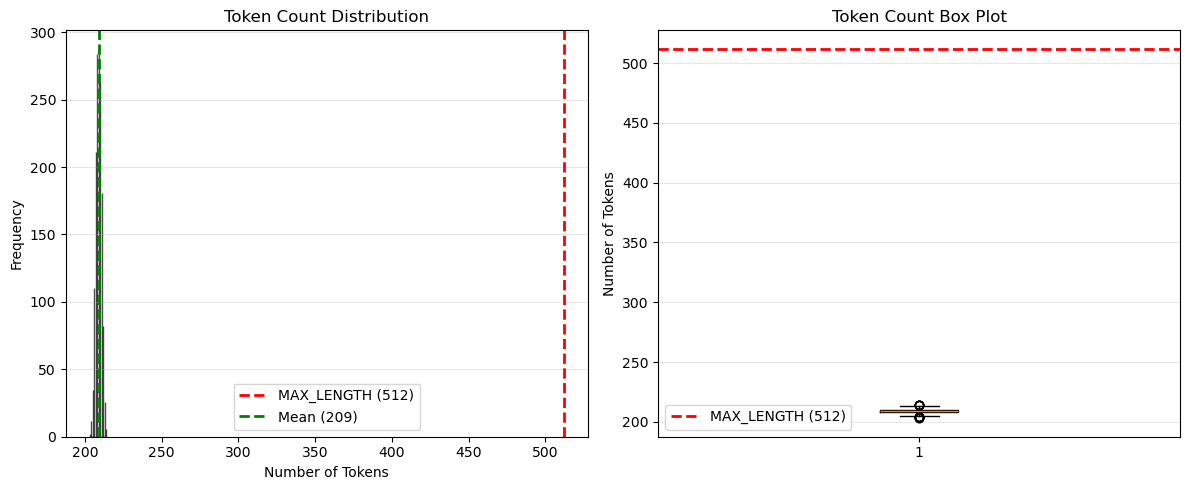

In [6]:
# Load dataset to inspect samples
sample_dataset = DGMDataset(DATA_PATH)

# Display feature columns being used
print(f"\nUsing {len(sample_dataset.get_feature_columns())} features:")
for i, col in enumerate(sample_dataset.get_feature_columns(), 1):
    print(f"  {i}. {col}")

# Calculate token statistics for all samples
print("\n" + "="*80)
print("Calculating token statistics for all samples...")
print("="*80)

token_counts = []

for i in tqdm(range(len(sample_dataset)), desc="Tokenizing samples"):
    sample = sample_dataset[i]
    text = sample['text']
    
    # Tokenize the text
    tokens = tokenizer(text, truncation=False, add_special_tokens=False)
    token_count = len(tokens['input_ids'])
    token_counts.append(token_count)

# Convert to numpy array for statistics
token_counts = np.array(token_counts)

# Calculate statistics
print(f"\nToken Count Statistics:")
print(f"  Total samples: {len(token_counts)}")
print(f"  Mean: {token_counts.mean():.2f}")
print(f"  Std: {token_counts.std():.2f}")
print(f"  Min: {token_counts.min()}")
print(f"  Max: {token_counts.max()}")
print(f"  Median: {np.median(token_counts):.2f}")
print(f"  25th percentile: {np.percentile(token_counts, 25):.2f}")
print(f"  75th percentile: {np.percentile(token_counts, 75):.2f}")
print(f"  95th percentile: {np.percentile(token_counts, 95):.2f}")
print(f"  99th percentile: {np.percentile(token_counts, 99):.2f}")

# Check how many samples exceed MAX_LENGTH
truncated_count = np.sum(token_counts > MAX_LENGTH)
print(f"\nSamples exceeding MAX_LENGTH ({MAX_LENGTH}): {truncated_count} ({100*truncated_count/len(token_counts):.2f}%)")

# Plot histogram
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(token_counts, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
plt.axvline(x=MAX_LENGTH, color='red', linestyle='--', linewidth=2, label=f'MAX_LENGTH ({MAX_LENGTH})')
plt.axvline(x=token_counts.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean ({token_counts.mean():.0f})')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Token Count Distribution')
plt.legend() 
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(token_counts, vert=True)
plt.axhline(y=MAX_LENGTH, color='red', linestyle='--', linewidth=2, label=f'MAX_LENGTH ({MAX_LENGTH})')
plt.ylabel('Number of Tokens')
plt.title('Token Count Box Plot')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Collate Function

Tokenize text sequences and prepare batch for BERT.

In [8]:
def collate_fn(batch):
    """Collate function for DataLoader with tokenization."""
    texts = [item['text'] for item in batch]
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)
    user_ids = [item['user_id'] for item in batch]
    
    # Tokenize texts
    encodings = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )
    
    return {
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'labels': labels,
        'user_ids': user_ids
    }

## Training Function

In [9]:
def train_model(model, train_loader, optimizer, device):
    """Train model for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in tqdm(train_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
    
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    
    return avg_loss, accuracy

## Evaluation Function

In [10]:
def evaluate_model(model, test_loader, device):
    """Evaluate model on test set."""
    model.eval()
    all_predictions = []
    all_labels = []
    total_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss += loss.item()
            
            predictions = torch.argmax(logits, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(test_loader) if len(test_loader) > 0 else 0
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='binary', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='binary', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='binary', zero_division=0)
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_predictions,
        'labels': all_labels
    }

## LOUO Cross-Validation

Leave-One-User-Out: Train on all users except one, test on the held-out user.

In [11]:
# Load full dataset
print("Loading dataset...")
full_dataset = DGMDataset(DATA_PATH)

# Get device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Get unique users for LOUO
unique_users = full_dataset.get_unique_users()
print(f"Found {len(unique_users)} unique users: {unique_users}")

# Storage for results
all_fold_results = []

# LOUO Cross-Validation
for fold, test_user in enumerate(unique_users):
    print(f"\n{'='*60}")
    print(f"Fold {fold+1}/{len(unique_users)} - Testing on User {test_user}")
    print(f"{'='*60}")
    
    # Split dataset by user
    train_indices = [i for i, user_id in enumerate(full_dataset.get_user_ids()) if user_id != test_user]
    test_indices = [i for i, user_id in enumerate(full_dataset.get_user_ids()) if user_id == test_user]
    
    print(f"Train samples: {len(train_indices)}, Test samples: {len(test_indices)}")
    
    # Handle edge case: no test samples
    if len(test_indices) == 0:
        print(f"Warning: No test samples for user {test_user}, skipping...")
        continue
    
    # Create subsets
    train_dataset = Subset(full_dataset, train_indices)
    test_dataset = Subset(full_dataset, test_indices)
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn
    )
    
    # Initialize model for this fold
    model = BertForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2,
        
    )
    
    # Resize token embeddings to account for [ROW] token
    model.resize_token_embeddings(len(tokenizer))
    model = model.to(device)
    
    # Initialize optimizer
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    
    # Training loop
    best_val_f1 = 0
    
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        
        # Train
        train_loss, train_acc = train_model(model, train_loader, optimizer, device)
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        
        # Evaluate
        results = evaluate_model(model, test_loader, device)
        print(f"Test Loss: {results['loss']:.4f}")
        print(f"Test Acc: {results['accuracy']:.4f}")
        print(f"Test Precision: {results['precision']:.4f}")
        print(f"Test Recall: {results['recall']:.4f}")
        print(f"Test F1: {results['f1']:.4f}")
    
    # Store final results for this fold
    final_results = evaluate_model(model, test_loader, device)
    final_results['test_user'] = test_user
    final_results['fold'] = fold
    all_fold_results.append(final_results)
    
    # Clean up
    del model, optimizer
    torch.cuda.empty_cache()

print(f"\n{'='*60}")
print("LOUO Cross-Validation Complete!")
print(f"{'='*60}")

Loading dataset...
Analyzing columns across all files...
Found 65 total numeric columns
Keeping 50 columns with valid data
Valid columns: ['average_pupil_size_of_both_eyes', 'average_pupil_size_of_left_eye', 'average_pupil_size_of_right_eye', 'convex_hull_area', 'delta_average_pupil_size_of_both_eyes', 'delta_average_pupil_size_of_left_eye', 'delta_average_pupil_size_of_right_eye', 'fixation_to_saccade_ratio', 'max_absolute_degree', 'max_fixation_duration_s', 'max_relative_degree', 'max_saccade_amplitude', 'max_saccade_duration', 'max_saccade_length', 'mean_absolute_degree', 'mean_fixation_duration_s', 'mean_relative_degree', 'mean_saccade_amplitude', 'mean_saccade_duration', 'mean_saccade_length', 'median_absolute_degree', 'median_fixation_duration_s', 'median_relative_degree', 'median_saccade_amplitude', 'median_saccade_duration', 'median_saccade_length', 'min_absolute_degree', 'min_fixation_duration_s', 'min_relative_degree', 'min_saccade_amplitude', 'min_saccade_duration', 'min_sac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 35.06it/s]


Train Loss: 0.6862, Train Acc: 0.5749


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.12it/s]


Test Loss: 0.8457
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.24it/s]


Train Loss: 0.6813, Train Acc: 0.5887


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 98.92it/s]


Test Loss: 0.9180
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:09<00:00, 36.32it/s]


Train Loss: 0.6805, Train Acc: 0.5818


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.22it/s]


Test Loss: 0.8598
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.27it/s]


Train Loss: 0.6870, Train Acc: 0.5742


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.18it/s]


Test Loss: 0.8064
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.21it/s]


Train Loss: 0.6835, Train Acc: 0.5694


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 99.70it/s]


Test Loss: 0.9278
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.04it/s]



Fold 2/30 - Testing on User 2
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.00it/s]


Train Loss: 0.7059, Train Acc: 0.5238


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.50it/s]


Test Loss: 0.5216
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.22it/s]


Train Loss: 0.6937, Train Acc: 0.5335


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.07it/s]


Test Loss: 0.7298
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.16it/s]


Train Loss: 0.6937, Train Acc: 0.5342


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 100.42it/s]


Test Loss: 0.5461
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.10it/s]


Train Loss: 0.6898, Train Acc: 0.5397


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.49it/s]


Test Loss: 0.5569
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.16it/s]


Train Loss: 0.6911, Train Acc: 0.5466


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.02it/s]


Test Loss: 0.5781
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 101.55it/s]



Fold 3/30 - Testing on User 3
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.17it/s]


Train Loss: 0.6965, Train Acc: 0.5245


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.24it/s]


Test Loss: 0.5274
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.16it/s]


Train Loss: 0.6919, Train Acc: 0.5431


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.92it/s]


Test Loss: 0.4946
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.21it/s]


Train Loss: 0.6925, Train Acc: 0.5349


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.02it/s]


Test Loss: 0.5569
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.17it/s]


Train Loss: 0.6914, Train Acc: 0.5466


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 97.37it/s]


Test Loss: 0.5522
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.14it/s]


Train Loss: 0.6922, Train Acc: 0.5507


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.83it/s]


Test Loss: 0.6142
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 101.19it/s]



Fold 4/30 - Testing on User 4
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.08it/s]


Train Loss: 0.6914, Train Acc: 0.5652


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.74it/s]


Test Loss: 0.8734
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.17it/s]


Train Loss: 0.6921, Train Acc: 0.5549


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.01it/s]


Test Loss: 0.9145
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.15it/s]


Train Loss: 0.6922, Train Acc: 0.5542


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.27it/s]


Test Loss: 1.0494
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.19it/s]


Train Loss: 0.6941, Train Acc: 0.5583


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.76it/s]


Test Loss: 0.8339
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.15it/s]


Train Loss: 0.6864, Train Acc: 0.5707


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.27it/s]


Test Loss: 0.8623
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.27it/s]



Fold 5/30 - Testing on User 6
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.16it/s]


Train Loss: 0.7031, Train Acc: 0.5045


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.98it/s]


Test Loss: 0.6288
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.09it/s]


Train Loss: 0.6953, Train Acc: 0.5217


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.17it/s]


Test Loss: 0.5779
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.09it/s]


Train Loss: 0.7005, Train Acc: 0.5245


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 101.08it/s]


Test Loss: 0.4617
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.27it/s]


Train Loss: 0.7050, Train Acc: 0.5079


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.07it/s]


Test Loss: 0.5862
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.16it/s]


Train Loss: 0.7014, Train Acc: 0.5204


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.51it/s]


Test Loss: 0.5327
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.98it/s]



Fold 6/30 - Testing on User 7
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.10it/s]


Train Loss: 0.7085, Train Acc: 0.5197


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 99.59it/s]


Test Loss: 0.5768
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.19it/s]


Train Loss: 0.6963, Train Acc: 0.5252


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.12it/s]


Test Loss: 0.5804
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.20it/s]


Train Loss: 0.6999, Train Acc: 0.5217


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.84it/s]


Test Loss: 0.6448
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.16it/s]


Train Loss: 0.6966, Train Acc: 0.5300


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 101.53it/s]


Test Loss: 0.5278
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.11it/s]


Train Loss: 0.6993, Train Acc: 0.5252


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.38it/s]


Test Loss: 0.8717
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 98.65it/s]



Fold 7/30 - Testing on User 8
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.15it/s]


Train Loss: 0.6850, Train Acc: 0.5769


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.26it/s]


Test Loss: 0.8400
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.23it/s]


Train Loss: 0.6825, Train Acc: 0.5825


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.24it/s]


Test Loss: 0.9009
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.21it/s]


Train Loss: 0.6830, Train Acc: 0.5845


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 96.36it/s]


Test Loss: 0.7611
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.09it/s]


Train Loss: 0.6843, Train Acc: 0.5714


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.57it/s]


Test Loss: 0.8656
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.22it/s]


Train Loss: 0.6823, Train Acc: 0.5852


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.36it/s]


Test Loss: 0.9364
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.68it/s]



Fold 8/30 - Testing on User 9
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.14it/s]


Train Loss: 0.6853, Train Acc: 0.5742


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.74it/s]


Test Loss: 1.1495
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.19it/s]


Train Loss: 0.6755, Train Acc: 0.5880


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.86it/s]


Test Loss: 0.8754
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.16it/s]


Train Loss: 0.6864, Train Acc: 0.5707


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 101.24it/s]


Test Loss: 1.0884
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.05it/s]


Train Loss: 0.6825, Train Acc: 0.5735


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 101.74it/s]


Test Loss: 0.8174
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.15it/s]


Train Loss: 0.6874, Train Acc: 0.5721


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.20it/s]


Test Loss: 1.0484
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.03it/s]



Fold 9/30 - Testing on User 10
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.11it/s]


Train Loss: 0.6850, Train Acc: 0.5804


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.87it/s]


Test Loss: 1.0494
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.12it/s]


Train Loss: 0.6899, Train Acc: 0.5659


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 100.96it/s]


Test Loss: 1.1294
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.14it/s]


Train Loss: 0.6879, Train Acc: 0.5604


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.97it/s]


Test Loss: 0.8246
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.15it/s]


Train Loss: 0.6853, Train Acc: 0.5673


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.72it/s]


Test Loss: 1.0756
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.24it/s]


Train Loss: 0.6876, Train Acc: 0.5735


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.55it/s]


Test Loss: 0.9790
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.37it/s]



Fold 10/30 - Testing on User 11
Train samples: 1450, Test samples: 49


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.13it/s]


Train Loss: 0.7058, Train Acc: 0.5283


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 104.24it/s]


Test Loss: 0.5920
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.15it/s]


Train Loss: 0.6987, Train Acc: 0.5124


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 104.80it/s]


Test Loss: 0.5386
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.10it/s]


Train Loss: 0.6981, Train Acc: 0.5297


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.15it/s]


Test Loss: 0.5907
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.10it/s]


Train Loss: 0.6998, Train Acc: 0.5193


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 104.69it/s]


Test Loss: 0.4590
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.26it/s]


Train Loss: 0.6985, Train Acc: 0.5200


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 101.62it/s]


Test Loss: 0.7238
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 104.89it/s]



Fold 11/30 - Testing on User 12
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.21it/s]


Train Loss: 0.6995, Train Acc: 0.5418


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.95it/s]


Test Loss: 0.6855
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.20it/s]


Train Loss: 0.6916, Train Acc: 0.5424


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.13it/s]


Test Loss: 0.8526
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.21it/s]


Train Loss: 0.6998, Train Acc: 0.5280


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.25it/s]


Test Loss: 0.6310
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.27it/s]


Train Loss: 0.6957, Train Acc: 0.5273


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.17it/s]


Test Loss: 0.5433
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:09<00:00, 36.30it/s]


Train Loss: 0.7023, Train Acc: 0.5141


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.64it/s]


Test Loss: 0.4840
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.56it/s]



Fold 12/30 - Testing on User 13
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.00it/s]


Train Loss: 0.6955, Train Acc: 0.5273


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 101.88it/s]


Test Loss: 0.5463
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.06it/s]


Train Loss: 0.6936, Train Acc: 0.5424


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 101.50it/s]


Test Loss: 0.5782
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.07it/s]


Train Loss: 0.6936, Train Acc: 0.5335


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.39it/s]


Test Loss: 0.5429
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.16it/s]


Train Loss: 0.6971, Train Acc: 0.5404


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.41it/s]


Test Loss: 0.6000
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.20it/s]


Train Loss: 0.7034, Train Acc: 0.5128


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 98.97it/s]


Test Loss: 0.5705
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.52it/s]



Fold 13/30 - Testing on User 14
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.15it/s]


Train Loss: 0.6891, Train Acc: 0.5493


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.29it/s]


Test Loss: 1.1193
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.15it/s]


Train Loss: 0.6835, Train Acc: 0.5680


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.19it/s]


Test Loss: 1.0523
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.12it/s]


Train Loss: 0.6854, Train Acc: 0.5735


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 100.04it/s]


Test Loss: 0.7855
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.14it/s]


Train Loss: 0.6825, Train Acc: 0.5763


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.46it/s]


Test Loss: 0.8127
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.19it/s]


Train Loss: 0.6831, Train Acc: 0.5687


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.25it/s]


Test Loss: 0.9703
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.02it/s]



Fold 14/30 - Testing on User 15
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.14it/s]


Train Loss: 0.7011, Train Acc: 0.5252


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.97it/s]


Test Loss: 0.5513
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.19it/s]


Train Loss: 0.6962, Train Acc: 0.5176


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.62it/s]


Test Loss: 0.6697
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.19it/s]


Train Loss: 0.6943, Train Acc: 0.5431


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.40it/s]


Test Loss: 0.6411
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.15it/s]


Train Loss: 0.6914, Train Acc: 0.5210


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.91it/s]


Test Loss: 0.6034
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.23it/s]


Train Loss: 0.6919, Train Acc: 0.5438


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.88it/s]


Test Loss: 0.6126
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 98.38it/s]



Fold 15/30 - Testing on User 16
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.18it/s]


Train Loss: 0.6857, Train Acc: 0.5590


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.36it/s]


Test Loss: 0.8628
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.26it/s]


Train Loss: 0.6890, Train Acc: 0.5721


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.29it/s]


Test Loss: 0.9996
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.28it/s]


Train Loss: 0.6828, Train Acc: 0.5714


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.52it/s]


Test Loss: 0.8898
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.19it/s]


Train Loss: 0.6861, Train Acc: 0.5673


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.54it/s]


Test Loss: 0.9840
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.15it/s]


Train Loss: 0.6915, Train Acc: 0.5687


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.69it/s]


Test Loss: 0.5618
Test Acc: 1.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.93it/s]



Fold 16/30 - Testing on User 17
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.05it/s]


Train Loss: 0.6940, Train Acc: 0.5514


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.05it/s]


Test Loss: 0.6991
Test Acc: 0.1400
Test Precision: 1.0000
Test Recall: 0.1400
Test F1: 0.2456

Epoch 2/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.06it/s]


Train Loss: 0.6928, Train Acc: 0.5286


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.24it/s]


Test Loss: 0.4287
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.06it/s]


Train Loss: 0.7008, Train Acc: 0.5328


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.67it/s]


Test Loss: 0.5535
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.10it/s]


Train Loss: 0.6976, Train Acc: 0.5293


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.63it/s]


Test Loss: 0.4762
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.18it/s]


Train Loss: 0.6968, Train Acc: 0.5314


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 98.17it/s]


Test Loss: 0.6499
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.62it/s]



Fold 17/30 - Testing on User 18
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 34.50it/s]


Train Loss: 0.6979, Train Acc: 0.5259


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 100.86it/s]


Test Loss: 0.7453
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:10<00:00, 34.93it/s]


Train Loss: 0.6963, Train Acc: 0.5135


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 91.97it/s]


Test Loss: 0.5237
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:10<00:00, 34.45it/s]


Train Loss: 0.6919, Train Acc: 0.5445


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 94.88it/s]


Test Loss: 0.4754
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:10<00:00, 35.13it/s]


Train Loss: 0.7015, Train Acc: 0.5286


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 99.24it/s]


Test Loss: 0.4858
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.17it/s]


Train Loss: 0.7005, Train Acc: 0.5197


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 96.55it/s]


Test Loss: 0.5537
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 100.81it/s]



Fold 18/30 - Testing on User 19
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 35.76it/s]


Train Loss: 0.6989, Train Acc: 0.5266


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 94.80it/s]


Test Loss: 0.5892
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:10<00:00, 35.84it/s]


Train Loss: 0.6915, Train Acc: 0.5418


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 101.75it/s]


Test Loss: 0.6700
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.10it/s]


Train Loss: 0.6934, Train Acc: 0.5480


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.75it/s]


Test Loss: 0.9344
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:10<00:00, 35.99it/s]


Train Loss: 0.6981, Train Acc: 0.5217


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 98.16it/s]


Test Loss: 0.5819
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.19it/s]


Train Loss: 0.6988, Train Acc: 0.5162


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.79it/s]


Test Loss: 0.5796
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.60it/s]



Fold 19/30 - Testing on User 21
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.15it/s]


Train Loss: 0.6900, Train Acc: 0.5535


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.75it/s]


Test Loss: 0.9621
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.17it/s]


Train Loss: 0.6932, Train Acc: 0.5625


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.12it/s]


Test Loss: 0.8831
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.15it/s]


Train Loss: 0.6779, Train Acc: 0.5845


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.32it/s]


Test Loss: 0.8144
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.22it/s]


Train Loss: 0.6808, Train Acc: 0.5839


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.89it/s]


Test Loss: 1.0203
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.19it/s]


Train Loss: 0.6837, Train Acc: 0.5832


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.83it/s]


Test Loss: 0.7967
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.37it/s]



Fold 20/30 - Testing on User 22
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.08it/s]


Train Loss: 0.6976, Train Acc: 0.5328


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.46it/s]


Test Loss: 0.6355
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.22it/s]


Train Loss: 0.6892, Train Acc: 0.5355


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.96it/s]


Test Loss: 0.4041
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.18it/s]


Train Loss: 0.6963, Train Acc: 0.5362


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.89it/s]


Test Loss: 0.5624
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.19it/s]


Train Loss: 0.6924, Train Acc: 0.5342


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.77it/s]


Test Loss: 0.5565
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.19it/s]


Train Loss: 0.6903, Train Acc: 0.5528


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 100.65it/s]


Test Loss: 0.5602
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.58it/s]



Fold 21/30 - Testing on User 23
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.13it/s]


Train Loss: 0.6931, Train Acc: 0.5480


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.80it/s]


Test Loss: 0.9532
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.00it/s]


Train Loss: 0.6877, Train Acc: 0.5687


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 98.77it/s]


Test Loss: 0.9024
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.06it/s]


Train Loss: 0.6946, Train Acc: 0.5625


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.31it/s]


Test Loss: 0.9284
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.16it/s]


Train Loss: 0.6853, Train Acc: 0.5721


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.17it/s]


Test Loss: 0.8187
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.17it/s]


Train Loss: 0.6888, Train Acc: 0.5914


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.94it/s]


Test Loss: 0.8350
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 104.18it/s]



Fold 22/30 - Testing on User 24
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.26it/s]


Train Loss: 0.6993, Train Acc: 0.5280


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.89it/s]


Test Loss: 0.6580
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:09<00:00, 36.31it/s]


Train Loss: 0.6902, Train Acc: 0.5424


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.90it/s]


Test Loss: 0.6324
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:09<00:00, 36.33it/s]


Train Loss: 0.6921, Train Acc: 0.5535


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.68it/s]


Test Loss: 0.5476
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:09<00:00, 36.32it/s]


Train Loss: 0.6939, Train Acc: 0.5397


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.90it/s]


Test Loss: 0.7415
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:09<00:00, 36.38it/s]


Train Loss: 0.6926, Train Acc: 0.5293


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 104.50it/s]


Test Loss: 0.5544
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 104.03it/s]



Fold 23/30 - Testing on User 25
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.24it/s]


Train Loss: 0.6983, Train Acc: 0.5404


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.58it/s]


Test Loss: 0.6285
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:09<00:00, 36.34it/s]


Train Loss: 0.6981, Train Acc: 0.5273


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.54it/s]


Test Loss: 0.6020
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:09<00:00, 36.34it/s]


Train Loss: 0.7043, Train Acc: 0.5176


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.97it/s]


Test Loss: 0.5204
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:09<00:00, 36.36it/s]


Train Loss: 0.6935, Train Acc: 0.5273


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.93it/s]


Test Loss: 0.6333
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:09<00:00, 36.31it/s]


Train Loss: 0.6919, Train Acc: 0.5362


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.76it/s]


Test Loss: 0.6480
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.97it/s]



Fold 24/30 - Testing on User 26
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.23it/s]


Train Loss: 0.6902, Train Acc: 0.5769


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 100.57it/s]


Test Loss: 1.1379
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.29it/s]


Train Loss: 0.6855, Train Acc: 0.5852


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.37it/s]


Test Loss: 0.7835
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.27it/s]


Train Loss: 0.6825, Train Acc: 0.5839


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.98it/s]


Test Loss: 0.9028
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.26it/s]


Train Loss: 0.6826, Train Acc: 0.5839


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.65it/s]


Test Loss: 0.9714
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.27it/s]


Train Loss: 0.6843, Train Acc: 0.5839


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 104.02it/s]


Test Loss: 0.8490
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.55it/s]



Fold 25/30 - Testing on User 27
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.12it/s]


Train Loss: 0.6945, Train Acc: 0.5390


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.76it/s]


Test Loss: 0.6839
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.17it/s]


Train Loss: 0.6918, Train Acc: 0.5383


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 100.15it/s]


Test Loss: 0.5714
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.14it/s]


Train Loss: 0.6916, Train Acc: 0.5493


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 100.37it/s]


Test Loss: 0.6419
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.15it/s]


Train Loss: 0.6938, Train Acc: 0.5259


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.53it/s]


Test Loss: 0.6798
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.16it/s]


Train Loss: 0.6918, Train Acc: 0.5293


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.99it/s]


Test Loss: 0.6400
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.35it/s]



Fold 26/30 - Testing on User 28
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 35.10it/s]


Train Loss: 0.6819, Train Acc: 0.5797


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 100.62it/s]


Test Loss: 0.9442
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:10<00:00, 35.09it/s]


Train Loss: 0.6847, Train Acc: 0.5859


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 94.99it/s]


Test Loss: 0.9261
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:10<00:00, 35.80it/s]


Train Loss: 0.6849, Train Acc: 0.5825


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.04it/s]


Test Loss: 0.7573
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.16it/s]


Train Loss: 0.6858, Train Acc: 0.5666


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 97.77it/s]


Test Loss: 0.9331
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:10<00:00, 35.92it/s]


Train Loss: 0.6820, Train Acc: 0.5832


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.77it/s]


Test Loss: 0.8703
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.77it/s]



Fold 27/30 - Testing on User 29
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.11it/s]


Train Loss: 0.6914, Train Acc: 0.5583


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 100.93it/s]


Test Loss: 0.8137
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.15it/s]


Train Loss: 0.6843, Train Acc: 0.5687


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 94.27it/s]


Test Loss: 0.9227
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.09it/s]


Train Loss: 0.6843, Train Acc: 0.5652


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 104.39it/s]


Test Loss: 1.0305
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.18it/s]


Train Loss: 0.6792, Train Acc: 0.5818


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.75it/s]


Test Loss: 0.6999
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.06it/s]


Train Loss: 0.6814, Train Acc: 0.5749


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 94.56it/s]


Test Loss: 0.9347
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 94.33it/s]



Fold 28/30 - Testing on User 30
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 35.21it/s]


Train Loss: 0.6970, Train Acc: 0.5183


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 96.39it/s]


Test Loss: 0.6204
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:10<00:00, 35.09it/s]


Train Loss: 0.6918, Train Acc: 0.5362


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 97.33it/s]


Test Loss: 0.6938
Test Acc: 0.0400
Test Precision: 1.0000
Test Recall: 0.0400
Test F1: 0.0769

Epoch 3/5


Training: 100%|██████████| 363/363 [00:10<00:00, 35.38it/s]


Train Loss: 0.6904, Train Acc: 0.5473


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.18it/s]


Test Loss: 0.7596
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:10<00:00, 34.91it/s]


Train Loss: 0.6917, Train Acc: 0.5424


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 102.50it/s]


Test Loss: 0.5472
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:10<00:00, 35.08it/s]


Train Loss: 0.6918, Train Acc: 0.5431


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 97.25it/s]


Test Loss: 0.6058
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 101.17it/s]



Fold 29/30 - Testing on User 31
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 35.10it/s]


Train Loss: 0.6929, Train Acc: 0.5431


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 94.99it/s]


Test Loss: 0.8040
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:10<00:00, 35.34it/s]


Train Loss: 0.6907, Train Acc: 0.5556


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 100.54it/s]


Test Loss: 0.9590
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:10<00:00, 35.39it/s]


Train Loss: 0.6834, Train Acc: 0.5673


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.18it/s]


Test Loss: 0.9056
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.04it/s]


Train Loss: 0.6862, Train Acc: 0.5852


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.69it/s]


Test Loss: 0.9367
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.20it/s]


Train Loss: 0.6864, Train Acc: 0.5687


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 98.53it/s]


Test Loss: 0.8705
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 104.48it/s]



Fold 30/30 - Testing on User 32
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.15it/s]


Train Loss: 0.7043, Train Acc: 0.5273


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.77it/s]


Test Loss: 0.5240
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.23it/s]


Train Loss: 0.6923, Train Acc: 0.5431


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.33it/s]


Test Loss: 0.4814
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.24it/s]


Train Loss: 0.7013, Train Acc: 0.5266


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.88it/s]


Test Loss: 0.6291
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.21it/s]


Train Loss: 0.6985, Train Acc: 0.5121


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 99.25it/s]


Test Loss: 0.6201
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [00:10<00:00, 36.18it/s]


Train Loss: 0.6964, Train Acc: 0.5231


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 103.52it/s]


Test Loss: 0.5742
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 104.18it/s]


LOUO Cross-Validation Complete!


## Aggregate Results Across Folds

In [12]:
# Calculate mean and std across all folds
if len(all_fold_results) > 0:
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    print("\n" + "="*60)
    print("LOUO Cross-Validation Results Summary")
    print("="*60)
    
    for metric in metrics:
        values = [result[metric] for result in all_fold_results]
        mean_val = np.mean(values)
        std_val = np.std(values)
        print(f"{metric.capitalize():12s}: {mean_val:.4f} ± {std_val:.4f}")
    
    # Create results dataframe
    results_df = pd.DataFrame([
        {
            'fold': r['fold'],
            'test_user': r['test_user'],
            'accuracy': r['accuracy'],
            'precision': r['precision'],
            'recall': r['recall'],
            'f1': r['f1']
        }
        for r in all_fold_results
    ])
    
    print("\nPer-Fold Results:")
    print(results_df.to_string(index=False))
else:
    print("No results to aggregate")


LOUO Cross-Validation Results Summary
Accuracy    : 0.5333 ± 0.4989
Precision   : 0.5000 ± 0.5000
Recall      : 0.5000 ± 0.5000
F1          : 0.5000 ± 0.5000

Per-Fold Results:
 fold  test_user  accuracy  precision  recall  f1
    0          1       0.0        0.0     0.0 0.0
    1          2       1.0        1.0     1.0 1.0
    2          3       1.0        1.0     1.0 1.0
    3          4       0.0        0.0     0.0 0.0
    4          6       1.0        1.0     1.0 1.0
    5          7       0.0        0.0     0.0 0.0
    6          8       0.0        0.0     0.0 0.0
    7          9       0.0        0.0     0.0 0.0
    8         10       0.0        0.0     0.0 0.0
    9         11       0.0        0.0     0.0 0.0
   10         12       1.0        1.0     1.0 1.0
   11         13       1.0        1.0     1.0 1.0
   12         14       0.0        0.0     0.0 0.0
   13         15       1.0        1.0     1.0 1.0
   14         16       1.0        0.0     0.0 0.0
   15         17      

## Visualize Results

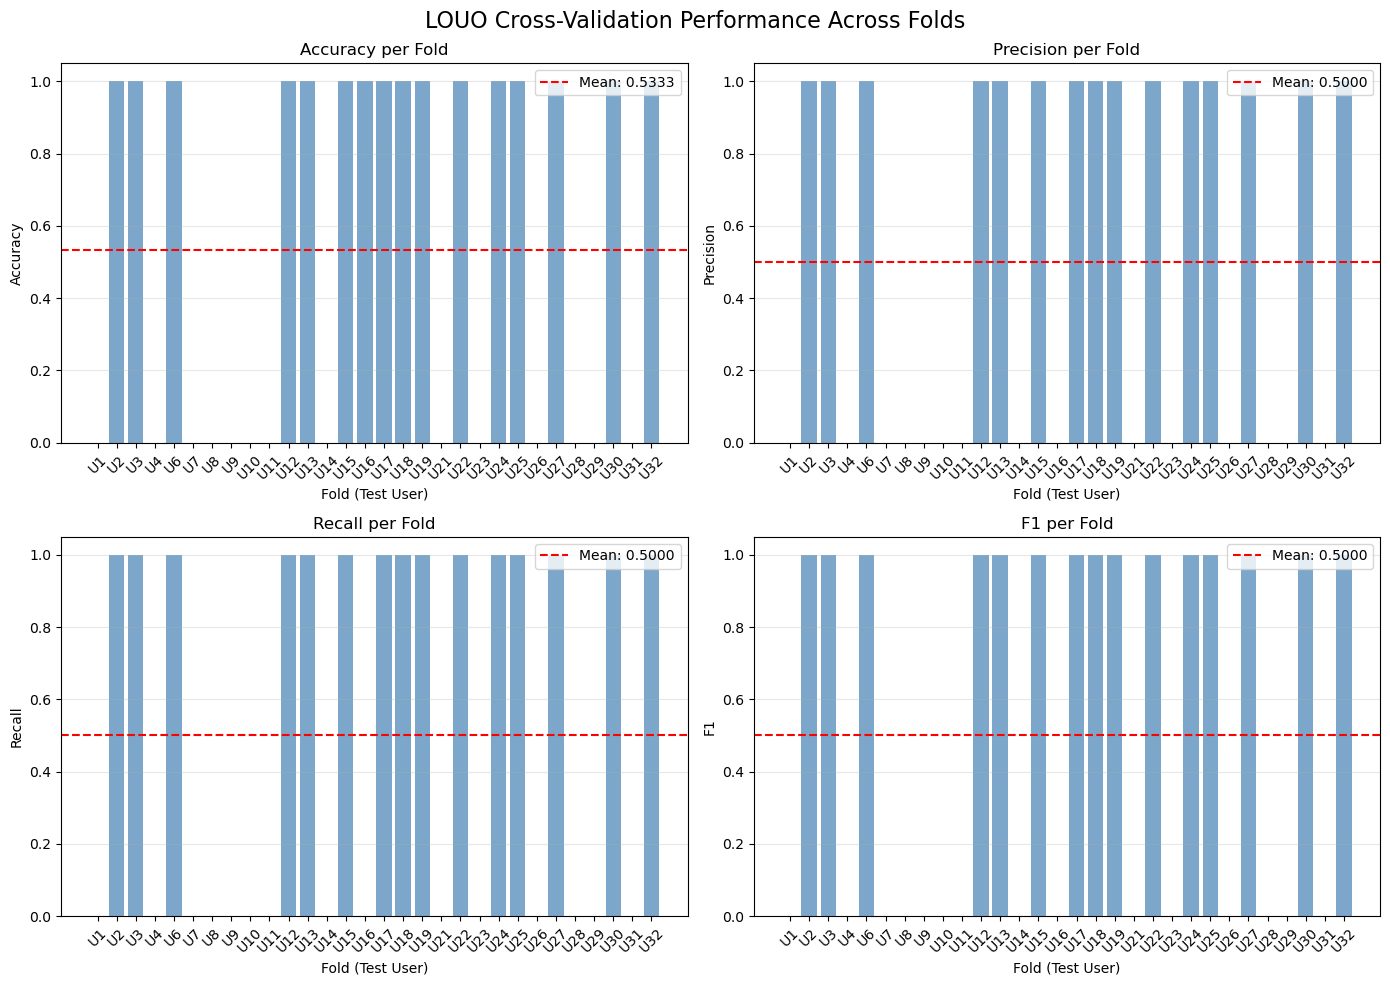

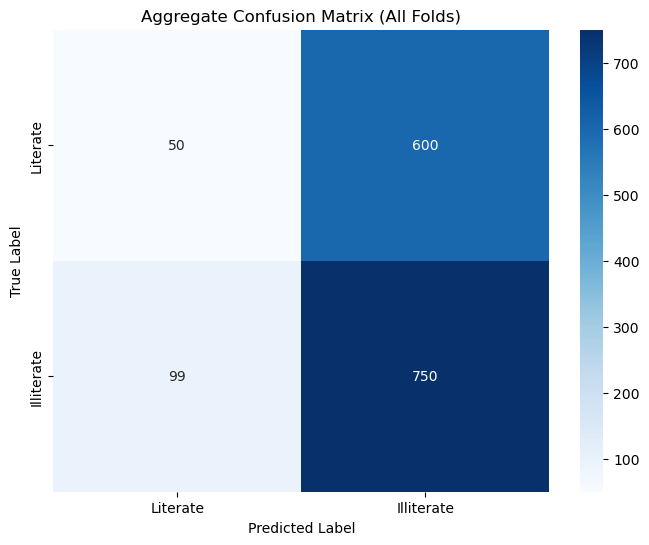

In [13]:
if len(all_fold_results) > 0:
    # Plot metrics across folds
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('LOUO Cross-Validation Performance Across Folds', fontsize=16)
    
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx // 2, idx % 2]
        values = [result[metric] for result in all_fold_results]
        users = [result['test_user'] for result in all_fold_results]
        
        ax.bar(range(len(values)), values, color='steelblue', alpha=0.7)
        ax.axhline(y=np.mean(values), color='red', linestyle='--', label=f'Mean: {np.mean(values):.4f}')
        ax.set_xlabel('Fold (Test User)')
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f'{metric.capitalize()} per Fold')
        ax.set_xticks(range(len(users)))
        ax.set_xticklabels([f"U{u}" for u in users], rotation=45)
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Plot confusion matrix (aggregate)
    all_predictions = []
    all_labels = []
    for result in all_fold_results:
        all_predictions.extend(result['predictions'])
        all_labels.extend(result['labels'])
    
    cm = confusion_matrix(all_labels, all_predictions)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Literate', 'Illiterate'],
                yticklabels=['Literate', 'Illiterate'])
    plt.title('Aggregate Confusion Matrix (All Folds)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
else:
    print("No results to visualize")